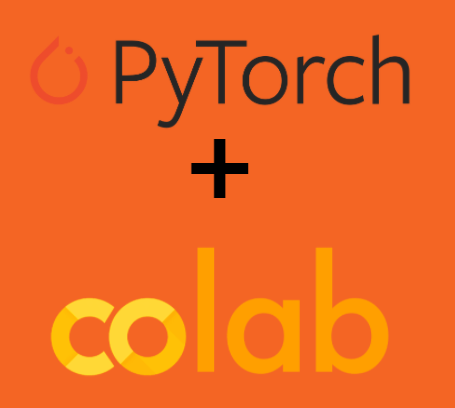

# **Auto-Encoder Tutorial**
##### *Tutorial for: Pitt RAS - Perception Sub-Team, Indy Autonomous Challenge*
##### *December 2020*
#####  *Morgan Visnesky*    

# **Purpose**
* In this tutorial we will be using Pytorch, Torchvision, and the MNIST dataset.
* We will be building off of Noah Gasparro's sub-team presentation and use of Pytorch and MNIST.
* The main goal will be to demonstrate the use of auto-encoders.

# Install Requirements

To start we need to install Pytorch and Torchvision.








In [ ]:
!pip3 install torch==1.7.0
!pip3 install torchvision==0.7.0


# Import Pytorch and other required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Now we need to grab the data sets we will be using for this tutorial.
As mentioned above, we will be using the MNIST dataset which can be downloaded using the torchvision.datasets module.
<br/>
Lets break down the following call to the datasets.MNIST() function:
```
train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)
```
`root="~/torch_datasets"` - The root parameter defines where the dataset will be saved.
<br/>
`train=True` - The train parameter is set to True because we are initializing the MNIST training dataset.
<br/>
`transform=transform` - The transforms parameter applies the transformations passed to it, in this case we are not manipulating the image, but just converting it to a pytorch tensor.
<br/>
`download=True` - The download parameter is set to True, which will download the dataset if it's not already present in our data folder.
<br/>
<br/>
The following call performs the same operation as above but grabs our test dataset.
<br/>
```
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)
```






In [ ]:
#MNIST dataset

# All the input transforms passed to transforms.compose are applied to the image input one by one
# transforms.ToTensor() converts a PIL Image or numpy.ndarray to tensor. No augmentation transforms are being applied in this case but those do exist.
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 

# MNIST dataset is included in the torchvision package

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

Pytorch's DataLoader and breaking down the following block of code:
<br/>
```
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)
```
`train_dataset ` - Passes our training dataset to the dataloader.
<br/> 
`batch_size=128` - Refers to the number of samples in each batch.

`shuffe=True` – Whether you want the data to be shuffled or not.

`num_workers=4` – Number of sub-processes needed for loading the data.

`pin_memory=True` – Pinned (page-locked) memory locations are used by GPUs for faster data access. When set to True, this option enables the data loader to copy tensors into the CUDA pinned memory.
<br/>
<br/>
The test_loader makes an identical call but loads in our testing dataset.

In [ ]:
# Loads training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

# loads testing dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

# Lets take a look at some of our data!

In [ ]:
# functions to show an image

def imshow(img):
    npimg = img.numpy()
    ax = plt.subplot(1,1,1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


print("Examples of our dataset:")
for i in range(5):
  # get some random training images
  dataiter = iter(train_loader)
  images, labels = dataiter.next()

  # show images
  imshow(torchvision.utils.make_grid(images[:8]))
  # print labels
  print(''.join('%5s' % str(labels[j]).strip('tensor(').rstrip(')') for j in range(8)))

# Defining our Auto-Encoder 
We will be using nn.Linear() layers for our auto-encoder and nn.ReLU() for our activation in our forward function.
### CLASS: torch.nn.Linear(in_features, out_features, bias=True)

- Applies a linear transformation to the incoming data: y = x*W<sup>T</sup> + b

Parameters:

- **in_features** – size of each input sample (i.e. size of x) <br />
- **out_features** – size of each output sample (i.e. size of y)<br />
- **bias** – If set to False, the layer will not learn an additive bias. Default: True
<br />
For each of the encoding and decoding layers the transforamtion described above takes place with arguments that respectively linearly 'downsample' and 'upsample' the image.

### CLASS: torch.nn.ReLU()
- Applies the rectified linear unit function elementwise to the incoming data: ReLU(x) = (x)<sup>+</sup> = max(0,x)

Parameters:
- Encoder/decoder layers with last ReLU layer passed as the current arguentment.


In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super(AE, self).__init__()
        # encoders
        self.encoder_1 = nn.Linear(in_features=kwargs["input_shape"], out_features=256) # downsamples from (28 X 28) to (16 X 16)
        self.encoder_2 = nn.Linear(in_features=256, out_features=128) # downsamples
        self.encoder_3 = nn.Linear(in_features=128, out_features=64) # downsamples
        self.encoder_4 = nn.Linear(in_features=64, out_features=32) # downsamples
        self.encoder_5 = nn.Linear(in_features=32, out_features=16) # downsamples to 4 x 4, or 16 total pixels
        self.encoder_6 = nn.Linear(in_features=16, out_features=4)
        # decoders 
        self.decoder_1 = nn.Linear(in_features=4, out_features=16) # upsamples
        self.decoder_2 = nn.Linear(in_features=16, out_features=32) # upsamples
        self.decoder_3 = nn.Linear(in_features=32, out_features=64) # upsamples
        self.decoder_4 = nn.Linear(in_features=64, out_features=128) # upsamples
        self.decoder_5 = nn.Linear(in_features=128, out_features=256) # upsamples
        self.decoder_6 = nn.Linear(in_features=256, out_features=kwargs["input_shape"]) # Final upsample to original size
    
    def forward(self, features):
        x = torch.relu(self.encoder_1(features))
        x = torch.relu(self.encoder_2(x))
        x = torch.relu(self.encoder_3(x))
        x = torch.relu(self.encoder_4(x))
        x = torch.relu(self.encoder_5(x))
        x = torch.relu(self.encoder_6(x))
        x = torch.relu(self.decoder_1(x))
        x = torch.relu(self.decoder_2(x))
        x = torch.relu(self.decoder_3(x))
        x = torch.relu(self.decoder_4(x))
        x = torch.relu(self.decoder_5(x))
        reconstruction = torch.relu(self.decoder_6(x))
        return reconstruction

In [ ]:
#  select GPU if one if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
model = AE(input_shape=784).to(device)

# visualize the encoder / docoder structure
print(model)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

# Training our Auto-encoder

Try changing the number of epochs to see how the results are affected.

In [ ]:
epochs = 5
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

# Visualizing the results

In [ ]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=True
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# **CITATIONS:**
* https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/
* https://towardsdatascience.com/implementing-an-autoencoder-in-tensorflow-2-0-5e86126e9f7
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/docs/stable/generated/torch.nn.Linear.html


# Further 

**Alternates to the nn.Linear layer**
<br/>

<table border="1" 
           align="left"> 
  <tr>
    <th>Function</th>
    <th>Operation</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>nn.conv2d</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>nn.fcl()</td>
    <td>-</td>
    <td>-</td>
  </tr>
</table>

<br/>
<br/>
<br/>
<br/>

**Activation Functions**
<br/>

<table border="1" 
           align="left"> 
  <tr>
    <th>Function</th>
    <th>Operation</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>nn.ReLU()</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>nn.softMax()</td>
    <td>-</td>
    <td>-</td>
  </tr>
</table>

<br/>
<br/>
<br/>
<br/>

**Loss Functions**
<br/>

<table border="1" 
           align="left"> 
  <tr>
    <th>Function</th>
    <th>Operation</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>nn.MSELoss()</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>nn.CrossEntropyLoss()</td>
    <td>-</td>
    <td>-</td>
  </tr>
</table>


